In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import pickle
import numpy as np

rc("font", **{"family": "serif", "serif": ["Times"]})
rc('text', usetex=True)

SINGLE_WIDTH = 246 / 72
DOUBLE_WIDTH = 510 / 72
GOLDEN_RATIO = (5**0.5 - 1) / 2
DATA_DIR = "../data"
SAVE_FIG = True
SAVE_DIR = "../figs"

Initial step size (rhobeg)

{'initial_point': [[1.2310672582, 1.5706881168]], 'maxeval': [4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 100], 'initial_step': [0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09, 0.09999999999999999, 0.11, 0.12, 0.13, 0.14, 0.15000000000000002, 0.16, 0.17, 0.18000000000000002, 0.19, 0.2], 'xtol_abs': [1e-10], 'executor_kwargs': [{'shots': None}]}
{'initial_point': [[0.9754194654, 1.7959753912, 2.2202413604, 1.1700312592]], 'maxeval': [6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 100], 'initial_step': [0.01, 0.02526315789473684, 0.04052631578947368, 0.05578947368421053, 0.07105263157894737, 0.0863157894736842, 0.10157894736842105, 0.11684210526315789, 0.13210526315789473, 0.1473684210526316, 0.16263157894736843, 0.17789473684210527, 0.1931578947368421, 0.20842105263157895, 0.2236842105263158, 0.23894736842105263, 0.25421052631578944, 0.2694736842105263, 0.2847368421052632, 0.3], 'xtol_abs': [1e-10], 'executor_kwargs': [{'shots': None}]}
{'initial_

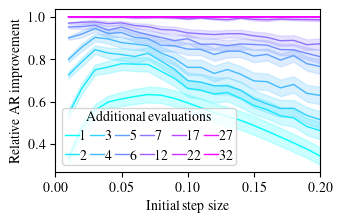

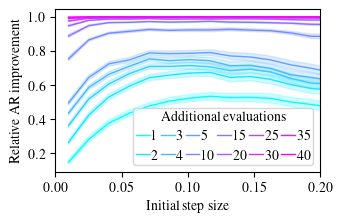

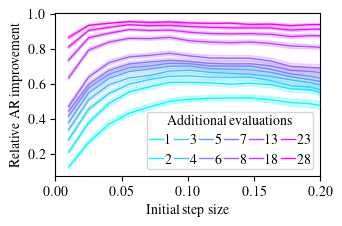

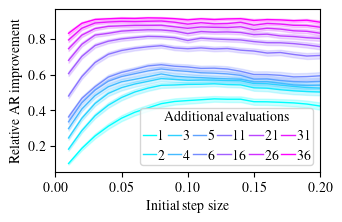

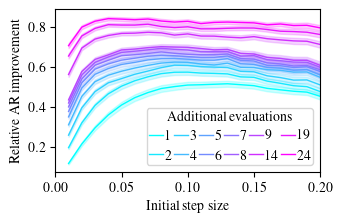

In [13]:
method = "LN_COBYLA (NLopt)"
problem = "maxcut"
depth_pool = [1, 2, 3, 4, 5]
qubit_pool = list(range(12, 13, 2))
n = 12
seed_pool = list(range(60 if problem == "po" else 100))

for p in depth_pool:
    result, initial_ar, max_ar = [], [], []
    for i, n in enumerate(qubit_pool):
        data = pickle.load(
            open(
                f"{DATA_DIR}/{problem}/configs/max_ar/{method}-p{p}-q{n}-s0-{59 if problem == 'po' else 999}.pckl",
                "rb",
            ),
        )
        max_ar.append(data["result"][: len(seed_pool)])

        data = pickle.load(
            open(
                f"{DATA_DIR}/{problem}/configs/rhobeg/{method}-p{p}-q{n}-s{seed_pool[0]}-{seed_pool[-1]}.pckl",
                "rb",
            ),
        )
        config = data["config"]
        maxfev_pool = config["maxeval"][:12]
        rhobeg_pool = config["initial_step"]
        result.append(data["result"])
        initial_ar.append(data["initial_ar"])
    result = np.array(result)
    initial_ar = np.array(initial_ar)[:, :, np.newaxis, np.newaxis]
    max_ar = np.array(max_ar)[:, :, np.newaxis, np.newaxis]
    # max_ar = result[:,:,-1,0][:,:,np.newaxis,np.newaxis]
    result = (result - initial_ar) / (max_ar - initial_ar)
    print(config)

    colors = mpl.colormaps["cool"](np.linspace(0, 1, len(maxfev_pool)))
    plt.figure(figsize=(SINGLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO))
    for j, (maxfev, color) in enumerate(zip(maxfev_pool, colors)):
        ys = result[:, :, j]
        y = np.mean(ys, axis=(0, 1))
        std_err = np.std(ys, axis=(0, 1)) / np.sqrt(len(seed_pool))
        plt.plot(
            rhobeg_pool,
            y,
            # yerr=std_err,
            label=f"{maxfev - 2 * p - 1}",
            color=color,
            linewidth=1,
        )
        plt.fill_between(rhobeg_pool, y - std_err, y + std_err, alpha=0.2, color=color)

    # plt.ylim((0, 1.05))
    plt.xlim((0, 0.2))
    plt.set_cmap("winter")
    plt.ylabel("Relative AR improvement")
    plt.xlabel("Initial step size")
    plt.xticks()
    plt.yticks()
    plt.legend(
        title="Additional evaluations",
        ncol=6,
        columnspacing=0.2,
        handletextpad=0.1,
        handlelength=1,
        borderpad=0.2,
    )
    if SAVE_FIG:
        plt.savefig(f"{SAVE_DIR}/{problem}/rhobeg/{method}-p{p}-q{n}.pdf")